In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [36]:
Cifar10 = tf.keras.datasets.cifar10

(x_train, y_train),(x_test, y_test) = Cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/255.0
x_train[0].shape

(32, 32, 3)

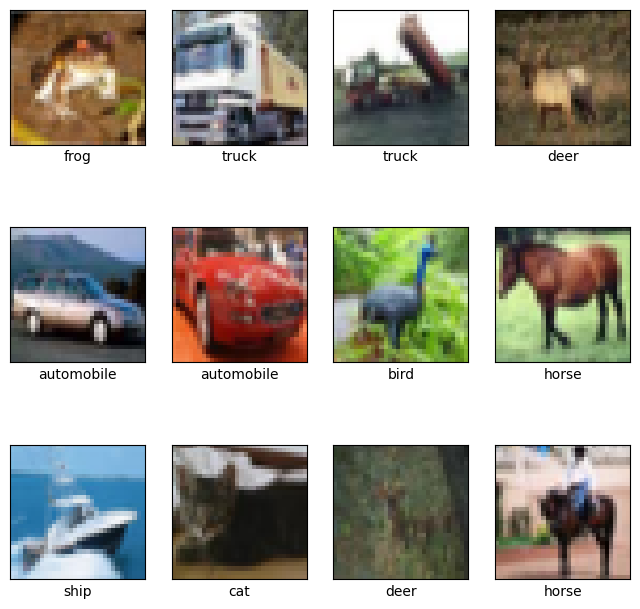

In [37]:
names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8,8))
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.imshow(x_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(names[y_train[i][0]])

plt.show()

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(20).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [39]:
class ModelCifar10(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(64,(3,3), activation="relu")
    self.b1 = BatchNormalization()
    self.m = MaxPooling2D(4,4)
    self.dropout = Dropout(0.5)
    self.dense1 = Dense(128, activation='relu')
    self.dense2 = Dense(10, activation='softmax')
    self.f = Flatten()

  def call(self, x):
    x = self.conv1(x)
    x = self.b1(x)
    x = self.m(x)
    x = self.dropout(x)
    x = self.f(x)
    x = self.dense1(x)
    x = self.dense2(x)
    return x


model = ModelCifar10()



In [40]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [41]:
train_loss = tf.keras.metrics.Mean()
test_loss = tf.keras.metrics.Mean()

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [42]:
@tf.function
def train(images, labels):
  with tf.GradientTape() as tape:
    pred = model(images)
    loss = loss_function(labels, pred)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, pred)

In [43]:
@tf.function
def test(image, labels):
  pred = model(images)
  loss = loss_function(labels, pred)

  test_loss(loss)
  test_accuracy(labels, pred)

In [ ]:
epochs = 24

for epoch in range(epochs):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  # train
  for images, labels in train_dataset:
    train(images, labels)

  # test
  for images, labels in test_dataset:
    test(images, labels)

print("epoch: ", epoch,
      f"train_loss: , {train_loss.result()}",
      f"train_accuracy: ,{train_accuracy.result()}",
      f"test_loss: , {test_loss.result()}",
      f"test_accuracy: ,{test_accuracy.result()}"
      )

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
import cv2

labels = ["airplane", "cars", "birds", "cats", "deer", "dogs", "frogs", "horses", "ships","trucks"]

image = cv2.imread("/content/airplane.jpg")
image = cv2.resize(image,(32,32))
image = image[tf.newaxis,...]
image = image.astype("float32")
image.shape

In [ ]:
pred = model(image)
result = np.argmax(pred)
label = labels[result]
label

In [ ]:
model.save("model_cifar10")
model = tf.keras.models.load_model("model_cifar10")